In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dynamiqs import wigner
import jax.numpy as jnp

In [70]:

def load_and_visualize_states(file_path):
    """
    Loads a Quantum-State-Pickle file and visualize the corresponding Wigner function
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"\nLade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            wigner_function = wigner(state)
            plt.contourf(wigner_function[0], wigner_function[1], wigner_function[2],levels=100, cmap='seismic', vmax=np.pi/2, vmin=-np.pi/2)
            plt.colorbar()
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [71]:

def compute_wigner_function(file_path):
    """
    Lädt alle Quantum-State Pickle-Dateien aus dem angegebenen Verzeichnis und visualisiert sie.
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"Lade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            wigner_function = wigner(state)
            return wigner_function
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")


Lade Datei: ../../../data/synthetic/quantum_state_1.pickle


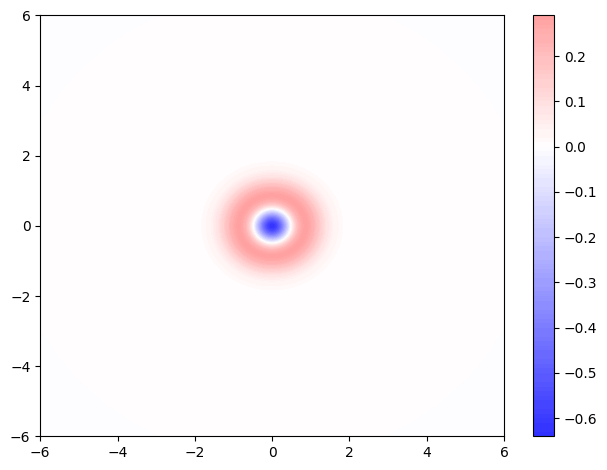

In [72]:
file_path = "../../../data/synthetic/quantum_state_1.pickle"
load_and_visualize_states(file_path) 

In [55]:
# Compute the Wigner function
file_path = "../../../data/synthetic/quantum_state_1.pickle"
wigner_fct = compute_wigner_function(file_path) 

Lade Datei: ../../../data/synthetic/quantum_state_1.pickle


In [95]:
# Choose a set of displacement points alpha_k
# Epsilon threshold
# Nahe am Maximum und Minimum samplen
# Evtl Gradienten miteinbeziehen

# Finde die Position des maximalen Wertes in der Wigner-Funktion
max_value = np.max(wigner_fct[2])
max_pos = np.where(wigner_fct[2] == max_value)  
x_max = wigner_fct[0][max_pos[0][0]] 
p_max = wigner_fct[1][max_pos[1][0]]
print(f"Maximum der Wigner-Funktion: {max_value}")
print(f"Position des Maximums: x = {x_max}, p = {p_max}")

# Translate grid
x_grid = wigner_fct[0] - x_max
p_grid = wigner_fct[1] - p_max

# Erstelle ein neues Gitter mit den verschobenen Werten
wigner_fct_shifted = (x_grid, p_grid, wigner_fct[2])

new_grid = np.meshgrid(x_grid, p_grid)

# Finde die Position des minimalen Wertes in der Wigner-Funktion
min_value = np.min(wigner_fct[2])
min_pos = np.where(wigner_fct[2] == min_value)  
x_min = wigner_fct[0][min_pos[0][0]] 
p_min = wigner_fct[1][min_pos[1][0]]
print(f"Minimum der Wigner-Funktion: {min_value}")
print(f"Position des Minimums: x = {x_min}, p = {p_min}")

# Definiere Schwellenwerte für das Sampling
threshold_max = 0.2 * max_value  # 80% des Maximalwerts
threshold_min = 0.2 * min_value - 0.1 # 20% des Minimalwerts

# Erstelle Maske für Werte oberhalb des Max-Schwellenwerts und unterhalb des Min-Schwellenwerts
mask = (wigner_fct_shifted[2] >= threshold_max) | (wigner_fct_shifted[2] <= threshold_min)

# Extrahiere die relevanten Punkte
rows, cols = np.where(mask)
x_sampled = x_grid[rows]
p_sampled = p_grid[cols]
w_sampled = wigner_fct_shifted[2][mask]

# Erstelle zufällige Stichproben aus den extrahierten Punkten - uniform sampling
n_samples = 200
indices = np.random.choice(len(x_sampled), n_samples, replace=False)

# Finale Stichproben
alpha_k_x = x_sampled[indices]
alpha_k_p = p_sampled[indices]
alpha_k = alpha_k_x + 1j * alpha_k_p

print(f"Anzahl der gesampelten Punkte: {len(alpha_k)}")


Maximum der Wigner-Funktion: 0.2840973138809204
Position des Maximums: x = -0.720000147819519, p = -0.4800001382827759
Minimum der Wigner-Funktion: -0.6366197466850281
Position des Minimums: x = 0.0, p = 0.0
Anzahl der gesampelten Punkte: 200


FileNotFoundError: [Errno 2] No such file or directory: 'images/200_uniformsampled_points_phase_space.png'

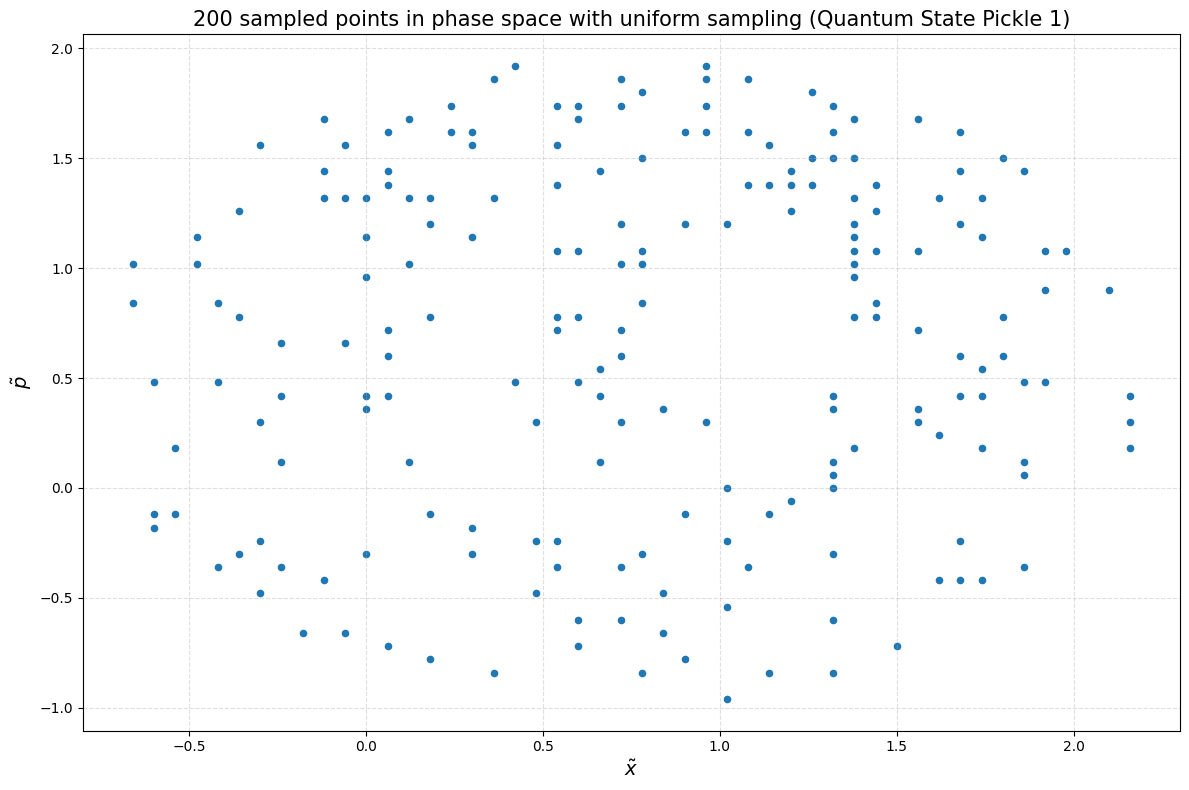

In [ ]:
# Scatterplot of the selected points
plt.figure(figsize=(12, 8))
plt.scatter(alpha_k_x, alpha_k_p, s=20)
plt.xlabel(r"$\tilde{x}$", fontsize=14)
plt.ylabel(r"$\tilde{p}$", fontsize=14)
plt.title("200 sampled points in phase space with uniform sampling (Quantum State Pickle 1)", fontsize=15)
#plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig('../../../images/200_uniformsampled_points_phase_space.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Map Wigner values to measurement probabilities
w_k = 0.5 * (1 + np.pi / 2 * wigner_fct(alpha_k))

In [ ]:
# Define the measurement operator E_{alpha_k}
E_alpha_k = 0.5 * () 

In [ ]:
# Fit the density matrix
import coptx


In [ ]:
# Optional task
# Ridge Regression! Rigde Kernel Regression!